# PROJECT. Построение рекомендательной системы.
### Цель проекта: Построить рекомендательную систему, благодаря которой можно будет предлагать клиентам интересные им курсы
Для этого нужно выполнить следующие этапы:
1. Подготовить необходимые данные с помощью SQL 
2. Обработать и проанализировать данные в Python
3. Сделать датафрейм с рекомендательной системой, где каждому курсу будет предлагаться 2 рекомендации
4. Сделать выводы и предложить дальнейшее решение


## 1. Подготовка данных SQL

На данном этапе мы должны получить таблицу с двумя столбцами: первый содержит user_id, а второй - course_id.
Будем выводить данные только для пользователей, купивших больше 1 курса.
Выполним следующий SQL запрос и сохраним данные в Final_Project.csv:

```with user_purch as
(
select *
from final.carts cs
join final.cart_items ci
on cs.id = ci.cart_id
where cs.state = 'successful' and ci.resource_type = 'Course'
)
select
	up.user_id,
	up.resource_id course_id
from user_purch up
where up.user_id in 
(
	select
	up.user_id
	from user_purch up
	group by up.user_id
	having count(distinct up.resource_id) > 1
)
```

## 2. Обработка и анализ в Python

Final_Project.csv файл, полученый на предыдущем этапе будем обрабатывать с помощью Python

### Подготовка датафрейма

In [1]:
# Импортируем дополнительные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from itertools import combinations

In [2]:
# Зачитываем полученные с SQL запроса данные в датафрейм
df = pd.read_csv('Final_Project.csv')

In [3]:
# Выведем первые 5 значений датафрейма
df.head()

,user_id,course_id
0,1010882,490
1,1010802,514
2,1120298,514
3,750528,552
4,191574,523


In [4]:
# Выведем информацию по данным: количество и тип данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34172 entries, 0 to 34171
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    34172 non-null  int64
 1   course_id  34172 non-null  int64
dtypes: int64(2)
memory usage: 534.1 KB


In [5]:
# Посчитаем количество уникальных значений для каждого столбца
df.nunique()

user_id      12656
course_id      126
dtype: int64

Согласно полученной таблице количество уникальных пользователей, купивших более 1 курса равно **12656**.
Количество различных курсов - **126**


In [6]:
# Отсортируем датафрейм по пользователям и курсам. Сохраним сортировку в текущем датафрейме
df.sort_values(by = ['user_id', 'course_id'], inplace = True)

In [7]:
# Нам нужно построить рекомендательную систему, для этого по каждому пользователю разбиваем все покупки на пары курсов.
# Так как возможна ситуация, когда пользователь приобрел курс несколько раз, необходимо убрать дубликаты курсов для таких пользователей.
# Сделаем это с помощью группировки датафрейма по 'user_id' и применим метод unique(), 
# который выведет для пользоватаеля только уникальные покупки
grouped_df = df.groupby(['user_id'])['course_id'].unique().reset_index()
grouped_df.head()

,user_id,course_id
0,51,"[516, 1099]"
1,6117,"[356, 357, 1125]"
2,10275,"[553, 1147]"
3,10457,"[361, 1138]"
4,17166,"[356, 357]"


Получился датафрейм, в котором каждому пользователю соответсвует список купленных им курсов

Новый датафрейм содержит уникальные значения покупок для каждого пользователя.
Теперь мы можем по каждому пользователю получить пары курсов. Для этого мы воспользуемся функцией-итератором combinations из пакета itertools. Эта функция разобьет наш список купленных курсов на пары. Воспользумся двумя циклами: первым пройдемся по каждому пользователю, а с помощью второго каждую пару курсов запишем в новый список pair_list


In [8]:
pair_list = []
for i in grouped_df['course_id']:
    for j in combinations(i,2):
        pair_list.append(j)
print (pair_list[0:5]) # выведем первые 5 пар

[(516, 1099), (356, 357), (356, 1125), (357, 1125), (553, 1147)]


In [9]:
# Посчитаем длину списка
len(pair_list)

40017

In [10]:
# Мы можем посчитать количество уникальных пар с помощью функции set(). Для этого на вход этого метода подадим список pair_list
# и возьмем длину len()
len(set(pair_list))

3989

Итого получилось 3989 уникальных пар курсов

In [11]:
# Загрузим полученный лист в Series
pair_series = pd.Series(pair_list)
pair_series.head()

0    (516, 1099)
1     (356, 357)
2    (356, 1125)
3    (357, 1125)
4    (553, 1147)
dtype: object

In [12]:
# На следующем шаге посчитаем для каждой пары количество повторений с помощью метода value_counts().
pair_df = pair_series.value_counts()
pair_df.head()

(551, 566)    797
(515, 551)    417
(489, 551)    311
(523, 551)    304
(566, 794)    290
dtype: int64

In [13]:
# Обновляем датафрейм с помощью метода reset_index. Получаем датафрейм с двумя колонками:
# первая с парами, вторая с количеством повторений
pair_df = pair_df.reset_index()
pair_df.head(10)

,index,0
0,"(551, 566)",797
1,"(515, 551)",417
2,"(489, 551)",311
3,"(523, 551)",304
4,"(566, 794)",290
5,"(489, 515)",286
6,"(490, 566)",253
7,"(570, 752)",247
8,"(490, 551)",247
9,"(569, 572)",216


In [14]:
# Переименуем колонки
pair_df.columns = ['pair', 'frequency']
pair_df.head()

,pair,frequency
0,"(551, 566)",797
1,"(515, 551)",417
2,"(489, 551)",311
3,"(523, 551)",304
4,"(566, 794)",290


In [15]:
# Для удобства обработки добавим колонки first и second, в которые запишем первый элемент и второй пары соответственно
first_elem = []
second_elem = []
for i in pair_df['pair']:
    first_elem.append(i[0])
    second_elem.append(i[1])
pair_df['first'] = first_elem
pair_df['second'] = second_elem

### Aнализ датафреймa

In [16]:
pair_df

,pair,frequency,first,second
0,"(551, 566)",797,551,566
1,"(515, 551)",417,515,551
2,"(489, 551)",311,489,551
3,"(523, 551)",304,523,551
4,"(566, 794)",290,566,794
...,...,...,...,...
3984,"(362, 1102)",1,362,1102
3985,"(836, 1101)",1,836,1101
3986,"(563, 659)",1,563,659
3987,"(507, 907)",1,507,907


При выводе датафрейма видно, что у нас есть самая популярная пара курсов 551/566: ее купили 797 раз. И эти курсы входят в другие популярные пары курсов. Так же видно, что есть уникальные пары, купленные только одним пользователем

In [17]:
# Сделаем новый датафрейм, в котором посчитаем частоту покупки по каждому курсу по всем парам, 
# и тем самым определим самые популярные курсы
lcourses = []
top_course = {}

for i in pair_df['first']:
    if i not in lcourses:
        lcourses.append(i)
for i in pair_df['second']:
    if i not in lcourses:
        lcourses.append(i)
        
for course in lcourses:
    top_course[str(course)] = pair_df[(pair_df['first'] == course) | (pair_df['second'] == course)]['frequency'].sum()

top_course_df = pd.DataFrame(top_course, index=['Total']).T   
top_course_df.sort_values(by = ['Total'], ascending=False, inplace = True)
top_course_df.head()

,Total
551,6074
566,4324
515,3277
523,3131
489,2928


Таким образом, **топ 5** самых популярных курсов выглядит так:
1. Курс **551** - 6074 раз куплен в паре
2. Курс **566** - 4324 раз куплен в паре
3. Курс **515** - 3277 раз куплен в паре
4. Курс **523** - 3131 раз куплен в паре
5. Курс **489** - 2928 раз куплен в паре


In [18]:
# Выведем уникальные значения по каждому столбцу
pair_df.nunique()

pair         3989
frequency     131
first         117
second        123
dtype: int64

Количество уникальных пар у нас по-прежнему 3989. А вот по частоте уникальных значений не так много. 
Построим гистограмму распределения по частоте

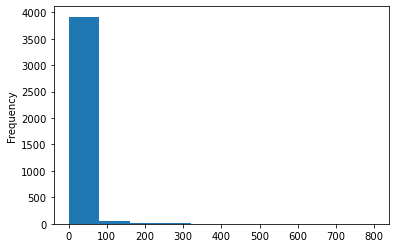

In [19]:
pair_df['frequency'].plot(kind = 'hist')

На гистограмме видно, что основное распределение пар идет между 0 и 100. Самые популярные пары курсов, купленные больше 100 раз, практически не видны. 
Построим 5 гистограмм с более детальной разбивкой

Text(0.5, 1.0, 'Частота от 100')

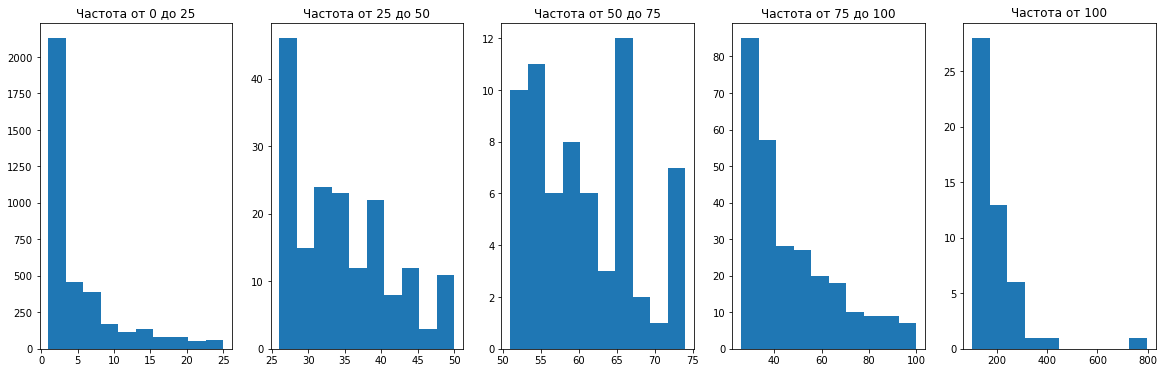

In [20]:
fig, axes = plt.subplots(1, 5, figsize = (20, 6))
axes[0].hist(pair_df[pair_df['frequency'] <= 25]['frequency'])
axes[0].set_title('Частота от 0 до 25')
axes[1].hist(pair_df[(pair_df['frequency'] > 25) & (pair_df['frequency'] <= 50)]['frequency'])
axes[1].set_title('Частота от 25 до 50')
axes[2].hist(pair_df[(pair_df['frequency'] > 50) & (pair_df['frequency'] <= 75)]['frequency'])
axes[2].set_title('Частота от 50 до 75')
axes[3].hist(pair_df[(pair_df['frequency'] > 25) & (pair_df['frequency'] <= 100)]['frequency'])
axes[3].set_title('Частота от 75 до 100')
axes[4].hist(pair_df[pair_df['frequency'] > 100]['frequency'])
axes[4].set_title('Частота от 100')

In [21]:
pair_df[pair_df['frequency'] < 5].count()

pair         2388
frequency    2388
first        2388
second       2388
dtype: int64

In [22]:
pair_df[pair_df['frequency'] == 1].count()

pair         1185
frequency    1185
first        1185
second       1185
dtype: int64

##### Вывод
Среди 3989 пар, 2388 пары, куплены менее 5 раз, и 1185 пар, куплены только 1 раз. Следовательно, вполне вероятна ситуация, когда в процессе построения рекомендаций мы к каким-то парам не сможем найти рекомендации или курсы, которые мы будем рекомендовать покупали очень редко. К сожалению, у нас нет в базе данных данных по тематике курсов (курсы по python, java или менеджменту). В этом случае мы будем предлагать самые популярные курсы: курс 551, как рекомендация номер 1, курс 566, как рекомендация номер 2 

### Рекомендательная система

In [23]:
def recommendation_dict(df):
    # Создаем пустой словарь, в котором каждому ключу будет соответствовать словарь с рекомендациями
    recom_dict = {}
    
    # Создадим пустой список, в котором соберем все курсы. Потом по нему будем проходить циклом и формировать рекомендации
    unique_course = []
    for course in df['first']:
        if course not in unique_course:
            unique_course.append(course)
    for course in df['second']:
        if course not in unique_course:
            unique_course.append(course)
            
    # Теперь пройдемся циклом по каждому курсу и заполним словарь рекомендациями  
    for i in unique_course:
        # Создаем словарь, в котором ключами будут рекомендация 1 и рекомендация 2
        rec_dict = {}
        
        # Создаем датафрейм, в котором выведем пары по курсу, отсортируем и возьмем первые 2 строки
        a = df[(df['first'] == i) | (df['second'] == i)].sort_values(by = ['frequency'], ascending = False).head(2)
        
        # добавляем условие добавления рекомендаций в словарь, если количество строк в датафрейме "а" больше 1
        if a['pair'].count() > 1:
            # Создаем рекомендацию №1
            if a['first'].iloc[0] == i:
                rec_dict['Recommendation_N1'] = a['second'].iloc[0]
                rec_dict['Frequency_N1'] = a['frequency'].iloc[0]
            else:
                rec_dict['Recommendation_N1'] = a['first'].iloc[0]
                rec_dict['Frequency_N1'] = a['frequency'].iloc[0]

            # Создаем рекомендацию №2
            if a['first'].iloc[1] == i:
                rec_dict['Recommendation_N2'] = a['second'].iloc[1]
                rec_dict['Frequency_N2'] = a['frequency'].iloc[1]
            else:
                rec_dict['Recommendation_N2'] = a['first'].iloc[1]
                rec_dict['Frequency_N2'] = a['frequency'].iloc[1]
        # Создаем ключ равный курсу и добавляем словарь с рекомендациями как его значение 
        recom_dict[i] = rec_dict
        
    # Сделаем проверку в получившемся словаре на отсутствие рекомендаций
    for i in recom_dict:
        if recom_dict[i]:
            count = 0
            for j in recom_dict[i]:
                count+=1
            if count < 4:
                print('Для курса {} только 1 рекомендация'.format(i))
        else:
            print('Для курса {} не нашлось рекомендаций'.format(i))         
    
    return recom_dict

In [24]:
# Применяем нашу функцию к датафрейму с парами курсов, транспонируем его и присваеваем его новому датафрейму
final_df = pd.DataFrame(recommendation_dict(pair_df)).T

In [25]:
# Выведем данные и посмотрим есть ли пропуски
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 551 to 1200
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Recommendation_N1  126 non-null    int64
 1   Frequency_N1       126 non-null    int64
 2   Recommendation_N2  126 non-null    int64
 3   Frequency_N2       126 non-null    int64
dtypes: int64(4)
memory usage: 4.9 KB


В получившемся датафрейме у нас нет пропущенных значений, значит функция обработала данные успешно. Теперь посмотрим, что у нас с данными

In [26]:
final_df[['Frequency_N1', 'Frequency_N2'] ].describe()

,Frequency_N1,Frequency_N2
count,126.000000,126.000000
mean,79.436508,55.595238
std,120.688458,71.667139
min,1.000000,1.000000
25%,16.250000,11.000000
50%,37.500000,27.000000
75%,97.250000,67.250000
max,797.000000,417.000000


Text(0.5, 1.0, 'Частота курсов по рекомендации 2')

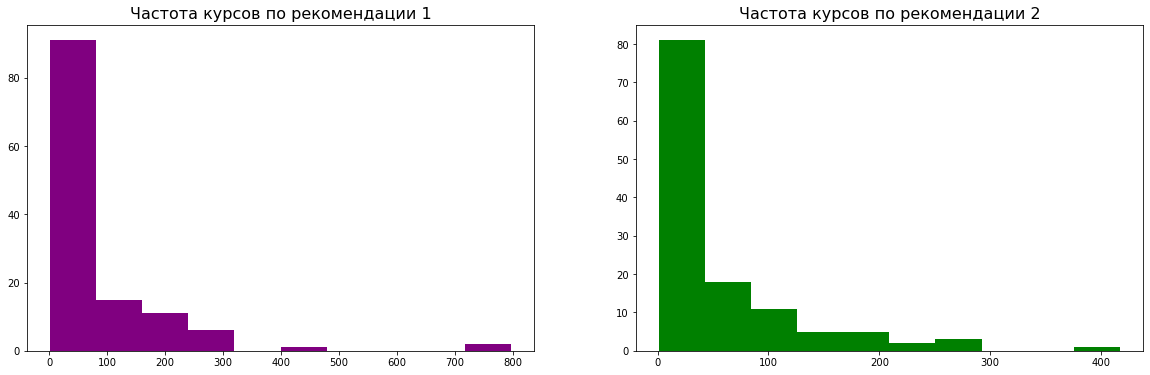

In [27]:
#final_df['Frequency_N1'].plot(kind = 'hist', color = 'Purple')

fig, axes = plt.subplots(1, 2, figsize = (20, 6))
axes[0].hist(final_df['Frequency_N1'], color = 'Purple')
axes[0].set_title('Частота курсов по рекомендации 1', fontdict = {'fontsize': 16})
axes[1].hist(final_df['Frequency_N2'],  color = 'Green')
axes[1].set_title('Частота курсов по рекомендации 2', fontdict = {'fontsize': 16})

Для обоих столбцов мы видим существенное различие медианны и среднего. Медианна в разы меньше среднего - это значит, что распределение смещено влево. 75% значений лежит в пределах от 1 до 97.25 для рекомендации 1 и от 1 до 67.25 для рекомендации 2. Самые популярные курсы находятся у нас выше третьего квартиля (Q3), мы их трогать не будем. В первом квартиле (Q1) находятся самые непопулярные пары курсов. В этом случае мы будем считать Q1 нижней границей и для всех курсов ниже (или равно) будем предлагать курс 551 в качестве рекомендации 1 и курс 566 в качестве рекомендации 2.

Итак нижняя граница для Recommendation_N1 = 16.25 и Recommendation_N2 = 11. 
Обработаем наш датафрейм и сформируем новые рекомендации для курсов с частотой меньше этих границ

In [28]:
# Отфильтруем датафрейм с этими границами и посмотрим на данные (возьмем первые 15 строк)
final_df[(final_df['Frequency_N1'] < 16.5) | (final_df['Frequency_N2'] < 11)].head(15)

,Recommendation_N1,Frequency_N1,Recommendation_N2,Frequency_N2
362,363,18,562,8
359,570,16,358,15
1124,1128,13,908,9
863,908,10,1100,8
865,829,7,1103,6
1146,745,17,516,9
364,551,6,664,5
670,490,16,566,15
744,551,16,566,16
813,672,18,361,7


Мы можем заметить, что среди рекомендаций у нас попались самые популярные курсы 551 и 566. Это нужно учесть для дальнейшей обработки. Будем их заменять 3м и 4м курсами по популярности
Алгоритм обработки будет следующий:
1. Если Recommendation_N1 = 551 и Recommendation_N2  566 (или наоборот) , то в рекомендации ставим курсы 3й и 4й по популярности (515 и 523 соответсвенно)
2. Eсли Recommendation_N1 = 551 и Recommendation_N2  515 (или наоборот), то в рекомендации ставим курсы 2й и 4й по популярности (566 и 523 соответсвенно)
3. Eсли Recommendation_N1 = 551 и Recommendation_N2  523 (или наоборот), то в рекомендации ставим курсы 2й и 3й по популярности (566 и 515 соответсвенно)
4. Eсли Recommendation_N1 = 566 и Recommendation_N2  515 (или наоборот), то в рекомендации ставим курсы 1й и 4й по популярности (551 и 523 соответсвенно)
6. Eсли Recommendation_N1 = 566 и Recommendation_N2  523 (или наоборот), то в рекомендации ставим курсы 1й и 3й по популярности (551 и 515 соответсвенно)
7. В остальных случаях ставим 551 и 556

Напишем функцию correct_recommendation, которая скорректирует наш датафрейм по алгоритму описанному выше


In [29]:
def correct_recommendation(df):
    for i in df.index:
        # Создаем переменные flag, они будут показывать нужно ли менять значения в рекомендации
        flag1 = 0
        flag2 = 0
        # Если значение ниже границы для рекомендации 1, то присваеваем переменной значение 1
        if df['Frequency_N1'].loc[i] < 16.5:
            flag1 = 1
        if df['Frequency_N2'].loc[i] < 11:
            flag2 = 1
            
        # Проверяем значения на принадлежность курсам из топ-4
        if (df['Recommendation_N1'].loc[i] == 551 and df['Recommendation_N2'].loc[i] == 566) or (df['Recommendation_N1'].loc[i] == 566 and df['Recommendation_N2'].loc[i] == 551):
            Rec1 = 515
            Rec2 = 523
        elif (df['Recommendation_N1'].loc[i] == 551 and df['Recommendation_N2'].loc[i] == 515) or (df['Recommendation_N1'].loc[i] == 515 and df['Recommendation_N2'].loc[i] == 551):
            Rec1 = 566
            Rec2 = 523
        elif (df['Recommendation_N1'].loc[i] == 551 and df['Recommendation_N2'].loc[i] == 523) or (df['Recommendation_N1'].loc[i] == 523 and df['Recommendation_N2'].loc[i] == 551):
            Rec1 = 566
            Rec2 = 515
        elif (df['Recommendation_N1'].loc[i] == 566 and df['Recommendation_N2'].loc[i] == 515) or (df['Recommendation_N1'].loc[i] == 515 and df['Recommendation_N2'].loc[i] == 566):
            Rec1 = 551
            Rec2 = 523    
        elif (df['Recommendation_N1'].loc[i] == 566 and df['Recommendation_N2'].loc[i] == 523) or (df['Recommendation_N1'].loc[i] == 523 and df['Recommendation_N2'].loc[i] == 566):
            Rec1 = 551
            Rec2 = 515
        else:
            Rec1 = 551
            Rec2 = 566
            
        # Проверяем значения флагов и присваем если условие верно новые значения
        if flag1 == 1:
            df['Recommendation_N1'].loc[i] = Rec1
        if flag2 == 1:
            df['Recommendation_N2'].loc[i] = Rec2
    return df

In [30]:
# Применяем функцию к датафрейму и формируем новый датафрейм с итоговыми рекомендациями
recommend_table = correct_recommendation(final_df)[['Recommendation_N1', 'Recommendation_N2']]
recommend_table = recommend_table.reset_index()
recommend_table.rename(columns = {'index': 'Course'}, inplace = True)

In [31]:
recommend_table

,Course,Recommendation_N1,Recommendation_N2
0,551,566,515
1,515,551,489
2,489,551,515
3,523,551,515
4,566,551,794
...,...,...,...
121,1199,551,566
122,833,551,566
123,1201,551,566
124,902,551,566


## Результаты

1. Данные SQL получены и обработаны в Python
2. Сформирована таблица с рекомендациями по курсам

## Предложения

1. Провести А/Б тест, где одной группе будут предлагаться рекомендации курсов, и оценить ключевые метрики: конверсия, возвращаемость, средний чек и ARPU/ARPPU
2. Ввести категоризацию курсов по тематике (Курсы по Питону, Курсы по Java, ..., и т.д.) для улучшения рекомендаций








